In [24]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import diags
from scipy.linalg import lu_factor, lu_solve
import matplotlib.pyplot as plt


In [2]:

def unitcell_batch(n, w_vals, d, t, e):
    """
    Build batched unitcell matrices for all w values.
    Returns shape: (batch, n, n)
    """
    w_vals = w_vals[:, None, None]  # (batch,1,1)

    base = (w_vals + 1j*d - e) * np.eye(n)[None, :, :]  # broadcast
    offdiag = t * np.eye(n, k=1)[None,:,:] + t * np.eye(n, k=-1)[None,:,:]

    return base + offdiag


In [4]:
unitcell_batch(6,np.arange(0,1,0.5),0.0001,1,0)

array([[[0. +0.0001j, 1. +0.j    , 0. +0.j    , 0. +0.j    ,
         0. +0.j    , 0. +0.j    ],
        [1. +0.j    , 0. +0.0001j, 1. +0.j    , 0. +0.j    ,
         0. +0.j    , 0. +0.j    ],
        [0. +0.j    , 1. +0.j    , 0. +0.0001j, 1. +0.j    ,
         0. +0.j    , 0. +0.j    ],
        [0. +0.j    , 0. +0.j    , 1. +0.j    , 0. +0.0001j,
         1. +0.j    , 0. +0.j    ],
        [0. +0.j    , 0. +0.j    , 0. +0.j    , 1. +0.j    ,
         0. +0.0001j, 1. +0.j    ],
        [0. +0.j    , 0. +0.j    , 0. +0.j    , 0. +0.j    ,
         1. +0.j    , 0. +0.0001j]],

       [[0.5+0.0001j, 1. +0.j    , 0. +0.j    , 0. +0.j    ,
         0. +0.j    , 0. +0.j    ],
        [1. +0.j    , 0.5+0.0001j, 1. +0.j    , 0. +0.j    ,
         0. +0.j    , 0. +0.j    ],
        [0. +0.j    , 1. +0.j    , 0.5+0.0001j, 1. +0.j    ,
         0. +0.j    , 0. +0.j    ],
        [0. +0.j    , 0. +0.j    , 1. +0.j    , 0.5+0.0001j,
         1. +0.j    , 0. +0.j    ],
        [0. +0.j    , 0. +0.

In [5]:

def hopping_znr_dense(n, t):
    """Dense version for vectorized operations."""
    H = np.zeros((n,n), dtype=complex)
    idx1 = np.arange(0, n-1, 4)
    idx2 = np.arange(3, n, 4)
    H[idx1, idx1+1] = t
    H[idx2, idx2-1] = t
    return H


In [51]:
from tqdm import tqdm


def leads_vectorized(n, w_vals, d, t, e, tol=1e-6, max_iter=200000):

    B = len(w_vals)                      # number of w points
    unit_batch = unitcell_batch(n, w_vals, d, t, e)   # (B,n,n)

    # invert each unitcell matrix (batched)
    lu_factors = [lu_factor(unit_batch[i]) for i in range(B)]
    g = np.stack([lu_solve(lu_factors[i], np.eye(n)) for i in range(B)])  # (B,n,n)

    G = g.copy()

    hopp = hopping_znr_dense(n, t)
    hoppT = hopp.T

    iden = np.eye(n)

    diff = np.inf
    count = 0

    # -------- tqdm progress bar --------
    pbar = tqdm(total=count, desc="Dyson iteration", leave=True)

    while diff > tol and count < max_iter:
        A = iden - g @ hoppT @ G @ hopp   # batch-matrix ops

        luA = [lu_factor(A[i]) for i in range(B)]
        G_new = np.stack([lu_solve(luA[i], g[i]) for i in range(B)])

        diff = np.max(np.abs(G_new - G))

        G = G_new
        count += 1

        pbar.update(1)
        pbar.set_postfix({"diff": diff})

    pbar.close()
    return G, count

In [52]:
def compute(n):
    w_vals = np.arange(0, 3, 0.01)

    G_all, iterations = leads_vectorized(
        n=6,
        w_vals=w_vals,
        d=1e-4,
        t=1,
        e=0
    )


    return G_all


In [53]:
compute(5)

Dyson iteration: 4it [00:00, 69.57it/s, diff=889]    

Dyson iteration: 59431it [03:51, 256.47it/s, diff=1e-6]    


array([[[ 0.00000000e+00-3.09398207e+02j,
          9.69060179e-01+0.00000000e+00j,
          0.00000000e+00+3.34060145e-01j,
         -1.38564557e+01+0.00000000e+00j,
          0.00000000e+00-3.32674500e-01j,
          1.38564225e+01+0.00000000e+00j],
        [ 9.69060179e-01-0.00000000e+00j,
          0.00000000e+00-9.69060179e-05j,
          3.34060145e-05+0.00000000e+00j,
          0.00000000e+00+1.38564557e-03j,
         -3.32674500e-05+0.00000000e+00j,
          0.00000000e+00-1.38564225e-03j],
        [ 0.00000000e+00+3.34060145e-01j,
          3.34060145e-05-0.00000000e+00j,
          0.00000000e+00-1.48254826e-03j,
          9.69026912e-01+0.00000000e+00j,
          0.00000000e+00+1.38564557e-03j,
         -9.69026773e-01+0.00000000e+00j],
        [-1.38564557e+01+0.00000000e+00j,
          0.00000000e+00+1.38564557e-03j,
          9.69026912e-01-0.00000000e+00j,
          0.00000000e+00-3.34063239e-01j,
          3.09396819e-02+0.00000000e+00j,
          0.00000000e+00+3.3406

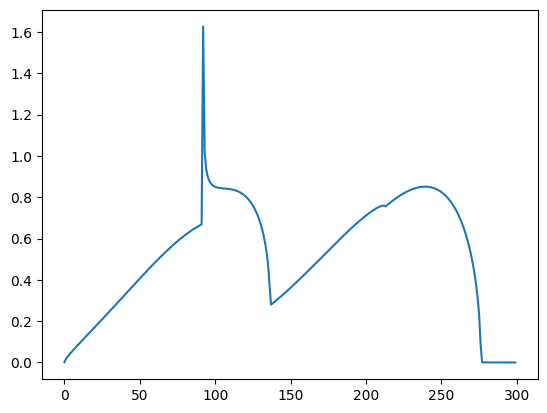

In [46]:
dos_1 = [] 

for w in range(len(G_all)):
    d1 = G_all[int(w)]
    dos_1.append(-np.imag(d1[2,2]))



plt.plot(dos_1)
#plt.ylim(0,10)

In [20]:
len(G_all)

600

In [28]:
def device(w, d, t, e):
    ene = int(w)
    m = 6

    SL = G_all[ene]     # left lead surface Green's function
    SR = G_all[ene]     # right lead
    T  = hopping_znr_dense(m, t)

    I = np.eye(m, dtype=complex)
    Td = T.conj().T

    IL = np.linalg.solve(I - SL @ Td @ SR @ Td, SL)
    IR = np.linalg.solve(I - SR @ Td @ SL @ Td, SR)

    gdd = IL - IL.conj().T
    grr = IR - IR.conj().T

    Gnonlocal = SR @ Td @ IL
    GNON = Gnonlocal - Gnonlocal.conj().T

    term1 = gdd @ T @ grr @ Td
    term2 = T @ GNON @ Td @ GNON

    tr1 = np.abs(np.trace(term1 - term2))

    return tr1


In [29]:
dos_il = []
dos_ir = []
for w in range(len(G_all)):

    il = device(w,0.001,1,0) 

    dos_il.append(il)


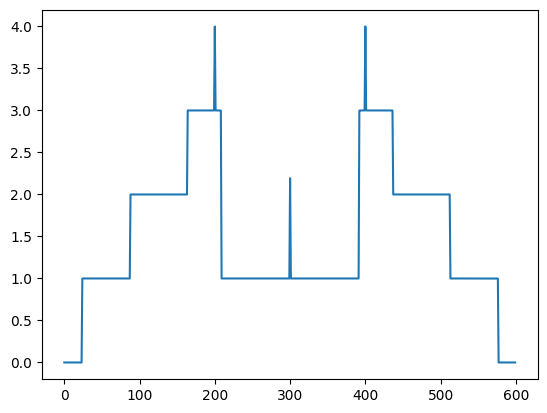

In [30]:
plt.plot(dos_il)
